# Some Preliminary Data Visualizations

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Getting the data
df = pd.read_csv("../Data/csvs/full_data.csv")

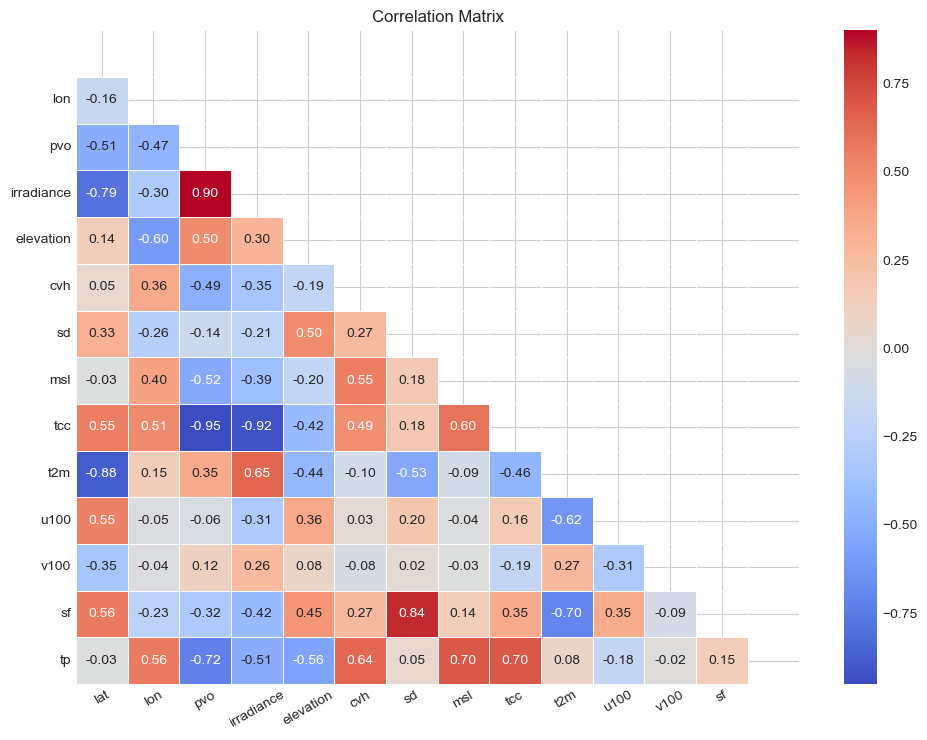

In [100]:
# Correlation matrix for all features

# Calculate correlation matrix
corr_mat = df.corr()

# Hiding upper right half
mask = np.triu(np.ones_like(corr_mat, dtype = bool))

# Plot using seaborn
fig, ax = plt.subplots(1, 1, figsize = (10, 7.5))
ax = sns.heatmap(corr_mat, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5, mask = mask)
ax.set_xticks([(i + 0.5) for i in range(13)])
ax.set_xticklabels(df.columns[: -1].to_list(), rotation = 30)
ax.set_yticks([(i + 1.5) for i in range(13)])
ax.set_yticklabels(df.columns[1:].to_list())
ax.set_title("Correlation Matrix")
plt.tight_layout()

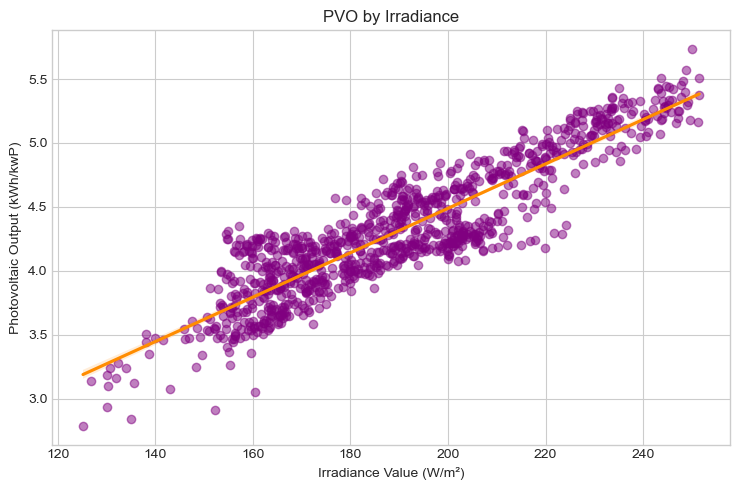

In [101]:
# Plotting PVO by irradiance - using a sample of the data
sample = df.sample(1000)
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.regplot(x = "irradiance", y = "pvo", data = sample, color = "darkorange", scatter = False)
ax.scatter(x = sample["irradiance"], y = sample["pvo"], color = "purple", alpha = 0.5)
ax.set_xlabel("Irradiance Value (W/m²)")
ax.set_ylabel("Photovoltaic Output (kWh/kwP)")
ax.set_title("PVO by Irradiance")
plt.tight_layout()

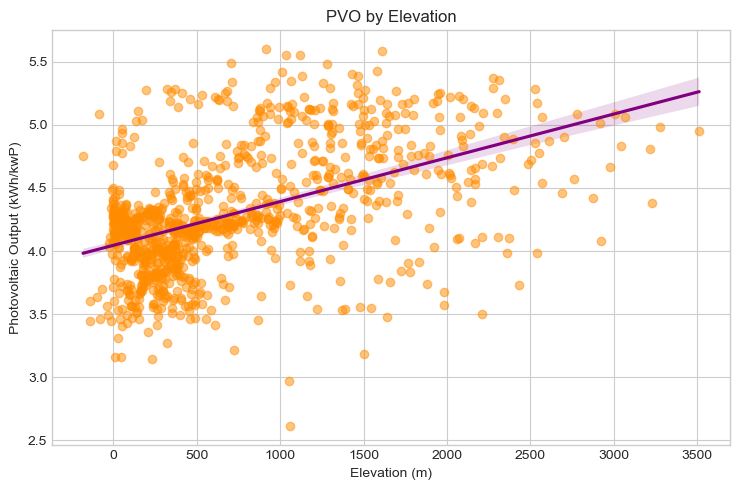

In [102]:
# Plotting PVO by irradiance - using a sample of the data
sample = df.sample(1000)
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.regplot(x = "elevation", y = "pvo", data = sample, color = "purple", scatter = False)
ax.scatter(x = sample["elevation"], y = sample["pvo"], color = "darkorange", alpha = 0.5)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Photovoltaic Output (kWh/kwP)")
ax.set_title("PVO by Elevation")
plt.tight_layout()